# Adversarial Search: Playing "Mean" Connect 4

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it back in the top of the same column. All disks above the removed disk will fall down one position and the removed one will be placed on top. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board. **Further, you are not allowed to play a mean move if your opponent just played one.** This ensures the game will end at some point. This also may affect the definition of a state, compared with standard Connect 4.

If a mean move causes both players to win, the game immediately ends and it is a tie, even if one player has more connect-4s than the other one. If a mean move causes one player to win, then the game also ends and the player with the connect-4 is the winner.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

In [47]:
# Initial state: player 1's turn on an empty board with mean moves allowed

# Actions: add one disc with player 1's color to one column that is not full, if it is player 1's turn
#          add one disc with player 2's color to one column that is not full, if it is player 2's turn
#          move one of player 2's discs from the bottom row to the top row of the same column if player 2 did not do so in player 2's previous turn, if it is player 1's turn
#          move one of player 1's discs from the bottom row to the top row of the same column if player 1 did not do so in player 1's previous turn, if it is player 2's turn

# Transition model: the added disc falls to lowest available space in the column that it is added to, if a disc is added
#                   the moved disc falls to lowest available space in its column after the other discs in the same column fall down by one space, if a disc is moved

# Test for the terminal state: if four discs of player 1's color form a horizontal, vertical, or diagonal line
#                              if four discs of player 2's color form a horizontal, vertical, or diagonal line
#                              if four discs of player 1's and four discs of player 2's respective colors form a horizontal, vertical, or diagonal line
#                              if no one has a line of four discs, the board is filled, and no mean moves can be played

# Utility for terminal states: -1 if player 1 loses, 0 if player 1 ties, and 1 if player 1 wins

How big is the state space? Give an estimate and explain it.

In [48]:
# Each of the 42 spaces on the board can be empty, player 1's disc, or player 2's disc, which is 3^42 possible board states.

# However, this accounts for states that can never be reached, such as states that would be reached if the game continued after a line of four discs being formed.

# As a result, the state space is much smaller than 3^(7*6) = 3^42.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [49]:
# Due to the restrictions on mean moves (can only move opponent's disc, disc must be on the bottom row, mean move can not be played consecutively),
# a good lower bound is the number of nodes in the game tree of ordinary Connect 4, which is approximately 7^42.

# This is because there are 7 columns to add discs to in each state and the game will definitively end when the board is filled with 42 discs.

# The number of nodes in the game tree of Connect 4 with mean moves is therefore more than 7^42, as mean moves can make the game last longer and will introduce a larger branching factor.

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [50]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(state, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

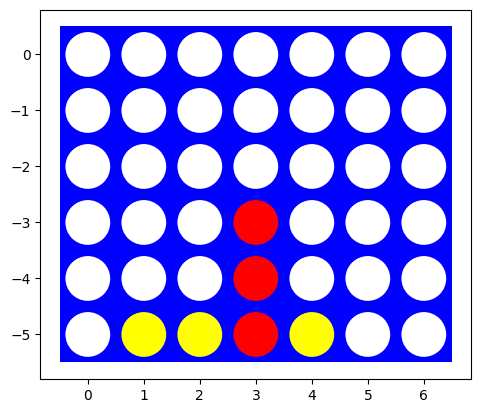

In [51]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [52]:
def result(s, a):
  """Returns the resulting state after applying the given action to the given state."""

  # unpack the state tuple
  s, player, mean_move = s

  # create a copy of the board
  s = s.copy()

  # unpack the action tuple
  action, col = a

  # if action is to add a disc
  if action == "add":
    # iterate through the rows of the column
    for i in range(len(s)):
      # go from bottom to top of column
      row = len(s) - 1 - i
      # if the board position is empty, place a disc there
      if s[row, col] == 0:
        s[row, col] = player
        break

  # else, if action is to move a disc
  elif action == "move":
    # store the disc that will be moved
    moved = s[len(s) - 1, col]
    # iterate through the rows of the column
    for i in range(1, len(s)):
      # go from bottom to top of column
      row = len(s) - 1 - i
      # move disc down
      s[row + 1, col] = s[row, col]
      # if board position is empty, move the disc below there
      if s[row, col] == 0:
        s[row + 1, col] = moved
        break
      # else, if row is the top row, move the disc there
      elif row == 0:
        s[row, col] = moved

  # return resulting board with flipped turn and whether or not a mean move was played
  if player == 1:
    return (s, -1, a[0] == "move")
  else:
    return (s, 1, a[0] == "move")

def utility(s):
  """Returns the utility of a state (-1, 0, 1)."""

  # unpack the state tuple
  s, player, mean_move = s

  # initialize variables
  filled = True
  win = {1: False, -1: False}

  # iterate through rows of board
  for i in range(len(s)):
    # iterate through columns of board
    for j in range(len(s[0])):
      # store disc at current board position
      disc = s[i, j]
      # if board position is empty, board is not filled
      if disc == 0:
        filled = False
      # else, check if the disc formed a line of four horizontally, vertically, and diagonally
      else:
        if j + 3 < len(s[0]) and s[i, j + 1] == disc and s[i, j + 2] == disc and s[i, j + 3] == disc:
          win[disc] = True
        if i - 3 >= 0 and s[i - 1, j] == disc and s[i - 2, j] == disc and s[i - 3, j] == disc:
          win[disc] = True
        if i - 3 >= 0 and j - 3 >= 0 and s[i - 1, j - 1] == disc and s[i - 2, j - 2] == disc and s[i - 3, j - 3] == disc:
          win[disc] = True
        if i - 3 >= 0 and j + 3 < len(s[0]) and s[i - 1, j + 1] == disc and s[i - 2, j + 2] == disc and s[i - 3, j + 3] == disc:
          win[disc] = True

  # if only player 1 wins, return 1
  if win[1] and not win[-1]:
    return 1
  # else, if only player -1 wins, return -1
  elif win[-1] and not win[1]:
    return -1
  # else, if board is filled and mean move has been played or if both players win, return 0
  elif (filled and mean_move) or (win[1] and win[-1]):
    return 0
  # else, not a terminal state and return None
  else:
    return None

def terminal(s):
  """Returns whether or not a state is a terminal state."""

  # unpack state tuple
  s, player, mean_move = s

  # return if utility is defined for the state
  return utility(s) != None

def actions(s):
  """Returns a list of valid actions for the given state."""

  # unpack the state tuple
  s, player, mean_move = s

  # intialize list of actions
  actions_lst = []

  # iterate through columns
  for i in range(len(s[0])):
    # if the top of the column is empty, a disc can be added to that column
    if s[0, i] == 0:
      actions_lst.append(("add", i))
    # if a mean move was not played in the previous turn
    if not mean_move:
      # store disc at the bottom of the column
      disc = s[len(s) - 1, i]
      # if the disc is the opponent's disc
      if disc != 0 and disc != player:
        # check if column only contains the opponent's discs (if so, moving the disc will not change the board)
        same = True
        for j in range(len(s)):
          if s[j, i] == player:
            same = False
            break
        # if column does not only contain the opponent's discs, the disc can be moved
        if not same:
          actions_lst.append(("move", i))

  # return the list of actions
  return actions_lst

Implement an agent that plays randomly. Make sure the agent function receives as the percept the game state and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(state, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [53]:
import random

def random_player(state, player=None):
  return random.choice(actions(state))

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [54]:
def play(x, y, n, size=(6,7), show=False, eval1=None, eval2=None, max_depth1=None, max_depth2=None):
  """Play agent x (1) and agent y (-1) against each other n times with a given board size and with x starting."""

  # initialize results dictionary
  results = {"x": 0, "y": 0, "t": 0}

  # loop n times
  for i in range(n):

    # create a new initial state
    state = (empty_board(size), 1, False)

    # loop until game is finished
    while True:

      # run the appropriate agent function based on the current player turn and if an evaluation function was provided
      if state[1] == 1:
        if eval1 == None:
          action = x(state)
        else:
          action = x(state, eval=eval1, max_depth=max_depth1)
      else:
        if eval2 == None:
          action = y(state)
        else:
          action = y(state, eval=eval2, max_depth=max_depth2)

      # update game state after action is applied
      state = result(state, action)

      # update results and end the game if the utility of the game state is not None
      util = utility(state)
      if util == 1:
        results["x"] += 1
        break
      elif util == 0:
        results["t"] += 1
        break
      elif util == -1:
        results["y"] += 1
        break

    # show board at the end of each game
    if show:
      visualize(state[0])

  # return the results
  return results

print(play(random_player, random_player, 1000, size=(6,7), show=False))
print("This result is expected because the player who goes first has an advantage as they can get 4 discs on the board before the other player.")

{'x': 567, 'y': 398, 't': 35}
This result is expected because the player who goes first has an advantage as they can get 4 discs on the board before the other player.


## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given state and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [55]:
import math

def max_value(state, alpha, beta, order, eval, depth, max_depth):
  """Returns the move that leads to the state with the highest value, as well as its value."""

  # if utility of current state is not None, return the utility
  util = utility(state)
  if util != None:
    return (util, None)
  # else, if maximum depth is reached, return the eval value for current state
  elif depth == max_depth:
    return (eval(state), None)

  # initialize variables
  v, move = -math.inf, None

  # store valid actions for current state and order it if an order function is provided
  actions_lst = actions(state)
  if order != None:
    order(actions_lst)

  # iterate through all actions
  for a in actions_lst:

    # call min_value to find value of state resulting from action
    v2, a2 = min_value(result(state, a), alpha, beta, order, eval, depth + 1, max_depth)

    # if new value is greater than best value so far, store new value and the corresponding move and update alpha
    if v2 > v:
      v, move = v2, a
      alpha = max(alpha, v)

    # return best value and move so far if best value so far is greater than or equal to beta (alpha-beta pruning)
    if v >= beta:
      return (v, move)

  # return best value and move after iterating through all actions
  return (v, move)

def min_value(state, alpha, beta, order, eval, depth, max_depth):
  """Returns the move that leads to the state with the lowest value, as well as its value."""

  # if utility of current state is not None, return the utility
  util = utility(state)
  if util != None:
    return (util, None)
  # else, if maximum depth is reached, return the eval value for current state
  elif depth == max_depth:
    return (eval(state), None)

  # initialize variables
  v, move = math.inf, None

  # store valid actions for current state and order it if an order function is provided
  actions_lst = actions(state)
  if order != None:
    order(actions_lst)

  # iterate through all actions
  for a in actions_lst:

    # call max_value to find value of state resulting from action
    v2, a2 = max_value(result(state, a), alpha, beta, order, eval, depth + 1, max_depth)

    # if new value is less than best value so far, store new value and the corresponding move and update beta
    if v2 < v:
      v, move = v2, a
      beta = min(beta, v)

    # return best value and move so far if best value so far is less than or equal to alpha (alpha-beta pruning)
    if v <= alpha:
      return (v, move)

  # return best value and move after iterating through all actions
  return (v, move)

def minimax_player(state, player=None, order=None, eval=None, max_depth=math.inf):
  """Returns an action from minimax search with alpha-beta pruning on a given state."""

  # if not used for heuristic alpha-beta tree search, choose a random action until a certain percentage of the board is filled with discs
  if eval == None:
    if np.sum(abs(state[0])) <= 0.25 * state[0].shape[0] * state[0].shape[1]:
      return random.choice(actions(state))

  # call max_value or min_value accordingly based on which player minimax search is (1 or -1)
  if state[1] == 1:
    value, move = max_value(state, -math.inf, math.inf, order, eval, 0, max_depth)
  else:
    value, move = min_value(state, -math.inf, math.inf, order, eval, 0, max_depth)

  # return the move
  return move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

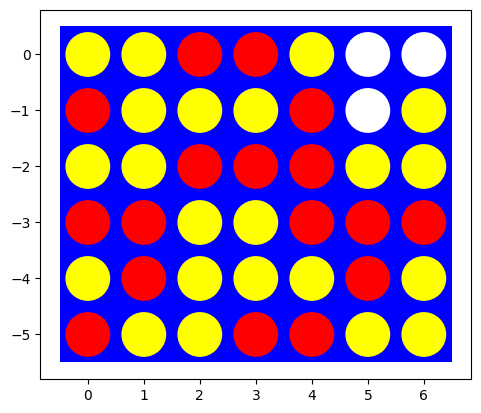

('move', 2) 




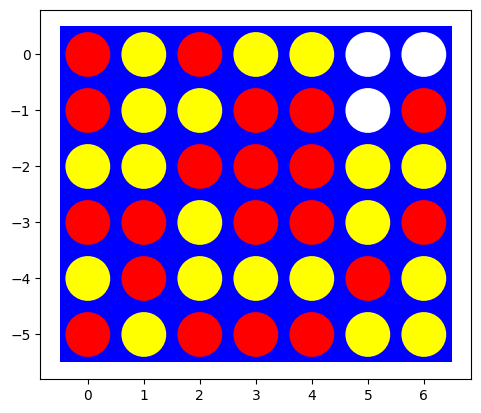

('add', 5) 




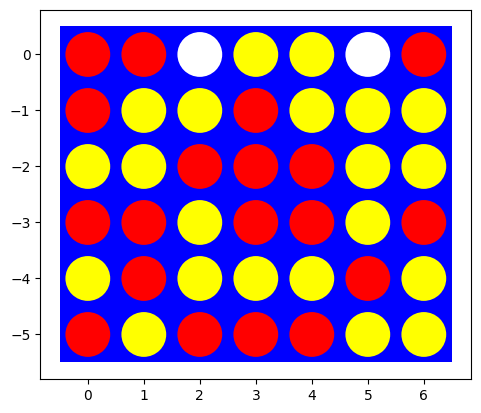

('move', 1) 




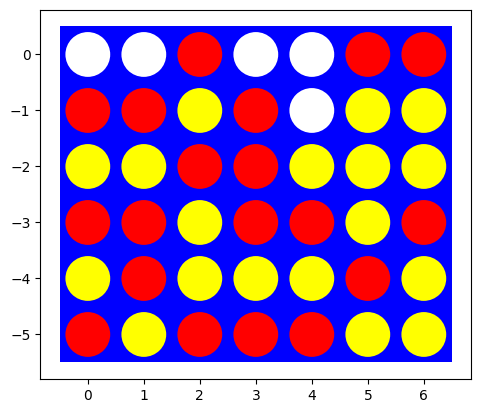

('add', 0) 




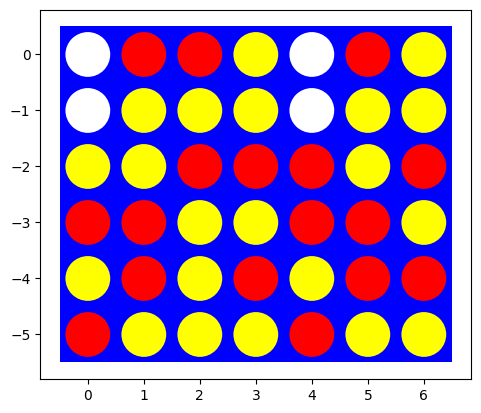

('move', 6) 


It does spot winning opportunities.


In [56]:
board = np.array([[-1, -1,  1,  1, -1,  0,  0],
                  [ 1, -1, -1, -1,  1,  0, -1],
                  [-1, -1,  1,  1,  1, -1, -1],
                  [ 1,  1, -1, -1,  1,  1,  1],
                  [-1,  1, -1, -1, -1,  1, -1],
                  [ 1, -1, -1,  1,  1, -1, -1]])
visualize(board)
print(minimax_player((board, 1, False)), "\n\n")

board = np.array([[ 1, -1,  1, -1, -1,  0,  0],
                  [ 1, -1, -1,  1,  1,  0,  1],
                  [-1, -1,  1,  1,  1, -1, -1],
                  [ 1,  1, -1,  1,  1, -1,  1],
                  [-1,  1, -1, -1, -1,  1, -1],
                  [ 1, -1,  1,  1,  1, -1, -1]])
visualize(board)
print(minimax_player((board, 1, False)), "\n\n")

board = np.array([[ 1,  1,  0, -1, -1,  0,  1],
                  [ 1, -1, -1,  1, -1, -1, -1],
                  [-1, -1,  1,  1,  1, -1, -1],
                  [ 1,  1, -1,  1,  1, -1,  1],
                  [-1,  1, -1, -1, -1,  1, -1],
                  [ 1, -1,  1,  1,  1, -1, -1]])
visualize(board)
print(minimax_player((board, 1, False)), "\n\n")

board = np.array([[ 0,  0,  1,  0,  0,  1,  1],
                  [ 1,  1, -1,  1,  0, -1, -1],
                  [-1, -1,  1,  1, -1, -1, -1],
                  [ 1,  1, -1,  1,  1, -1,  1],
                  [-1,  1, -1, -1, -1,  1, -1],
                  [ 1, -1,  1,  1,  1, -1, -1]])
visualize(board)
print(minimax_player((board, 1, False)), "\n\n")

board = np.array([[ 0,  1,  1, -1,  0,  1, -1],
                  [ 0, -1, -1, -1,  0, -1, -1],
                  [-1, -1,  1,  1,  1, -1,  1],
                  [ 1,  1, -1, -1,  1,  1, -1],
                  [-1,  1, -1,  1, -1,  1,  1],
                  [ 1, -1, -1, -1,  1, -1, -1]])
visualize(board)
print(minimax_player((board, 1, False)), "\n\n")

print("It does spot winning opportunities.")

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

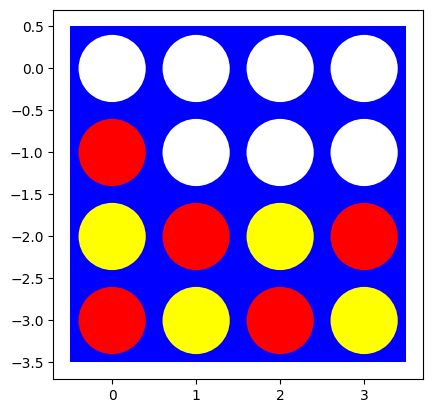

('add', 0)
The 4x4 board took: 0.1841437816619873 seconds




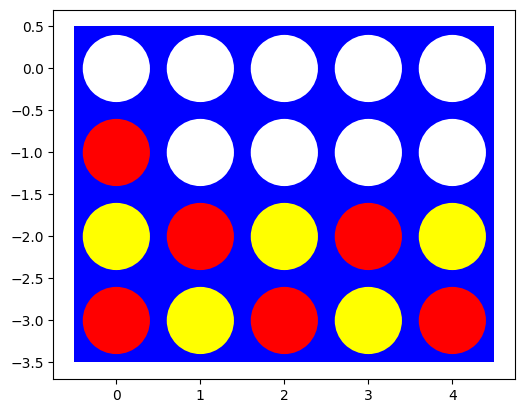

('add', 0)
The 4x5 board took: 3.8236355781555176 seconds




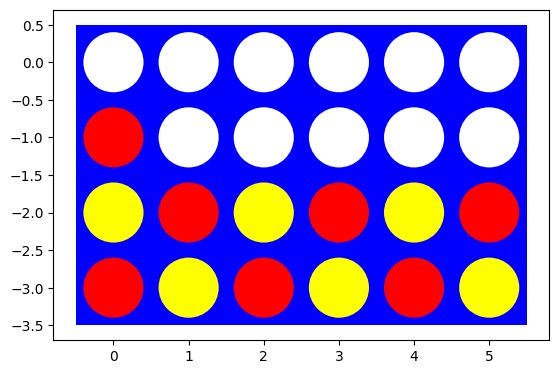

('add', 0)
The 4x6 board took: 188.0182068347931 seconds




In [57]:
import time

board = np.array([[ 0,  0,  0,  0],
                  [ 1,  0,  0,  0],
                  [-1,  1, -1,  1],
                  [ 1, -1,  1, -1]])
visualize(board)
t0 = time.time()
print(minimax_player((board, 1, False), eval="no random"))
t1 = time.time()
print(f"The 4x4 board took: {t1-t0} seconds\n\n")

board = np.array([[ 0,  0,  0,  0,  0],
                  [ 1,  0,  0,  0,  0],
                  [-1,  1, -1,  1, -1],
                  [ 1, -1,  1, -1,  1]])
visualize(board)
t0 = time.time()
print(minimax_player((board, 1, False), eval="no random"))
t1 = time.time()
print(f"The 4x5 board took: {t1-t0} seconds\n\n")

board = np.array([[ 0,  0,  0,  0,  0,  0],
                  [ 1,  0,  0,  0,  0,  0],
                  [-1,  1, -1,  1, -1,  1],
                  [ 1, -1,  1, -1,  1, -1]])
visualize(board)
t0 = time.time()
print(minimax_player((board, 1, False), eval="no random"))
t1 = time.time()
print(f"The 4x6 board took: {t1-t0} seconds\n\n")

### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move.

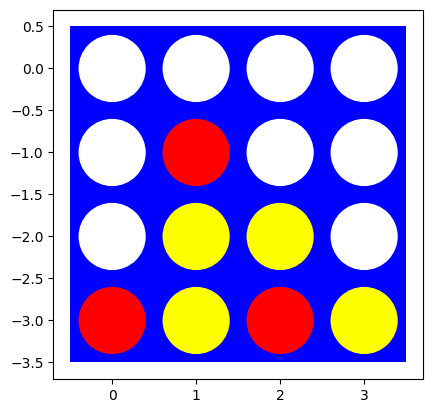

('add', 3)
('add', 3)
('add', 3)
('add', 3)
('add', 3)
Minimax with ordering by random took (on average): 1.5814133644104005 seconds

('add', 3)
Minimax with ordering by column took: 0.9271042346954346 seconds

('add', 3)
Minimax with ordering by adding discs before moving discs took: 1.5411286354064941 seconds

('add', 3)
Minimax with ordering by moving discs before adding discs took: 1.2292335033416748 seconds



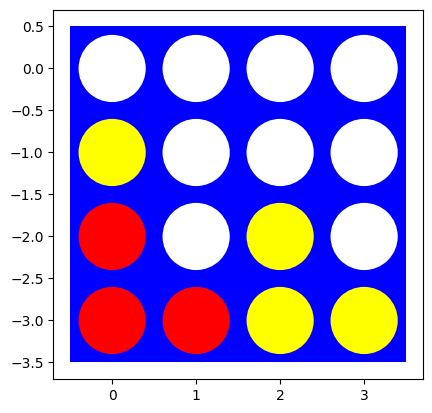

('add', 0)
('add', 3)
('add', 2)
('add', 0)
('add', 0)
Minimax with ordering by random took (on average): 0.845694637298584 seconds

('add', 0)
Minimax with ordering by column took: 1.572425365447998 seconds

('add', 0)
Minimax with ordering by adding discs before moving discs took: 0.42749643325805664 seconds

('add', 0)
Minimax with ordering by moving discs before adding discs took: 1.076653242111206 seconds



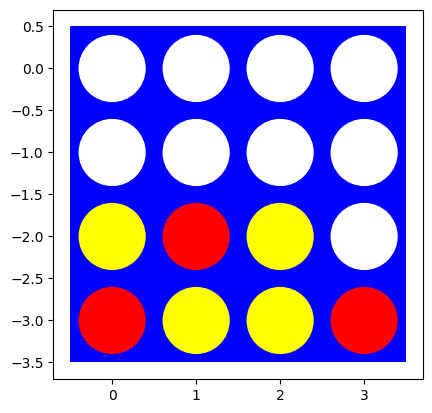

('add', 3)
('add', 2)
('add', 3)
('add', 3)
('add', 3)
Minimax with ordering by random took (on average): 1.361885166168213 seconds

('add', 2)
Minimax with ordering by column took: 5.43434739112854 seconds

('add', 2)
Minimax with ordering by adding discs before moving discs took: 2.680300235748291 seconds

('add', 2)
Minimax with ordering by moving discs before adding discs took: 5.569396734237671 seconds



In [58]:
def order_randomly(moves):
  random.shuffle(moves)

def order_by_move(moves):
  moves.sort(key=lambda x: x[0])

def order_by_move_r(moves):
  moves.sort(reverse=True, key=lambda x: x[0])

board1 = np.array([[ 0,  0,  0,  0],
                   [ 0,  1,  0,  0],
                   [ 0, -1, -1,  0],
                   [ 1, -1,  1, -1]])
board2 = np.array([[ 0,  0,  0,  0],
                   [-1,  0,  0,  0],
                   [ 1,  0, -1,  0],
                   [ 1,  1, -1, -1]])
board3 = np.array([[ 0,  0,  0,  0],
                   [ 0,  0,  0,  0],
                   [-1,  1, -1,  0],
                   [ 1, -1, -1,  1]])
boards = [board1, board2, board3]

for i in range(3):
  visualize(boards[i])

  temp = 0
  for j in range(5):
    t0 = time.time()
    print(minimax_player((boards[i], 1, False), order=order_randomly, eval="no random"))
    t1 = time.time()
    temp += t1 - t0
  print(f"Minimax with ordering by random took (on average): {temp/5} seconds\n")

  t0 = time.time()
  print(minimax_player((boards[i], 1, False), order=None, eval="no random"))
  t1 = time.time()
  print(f"Minimax with ordering by column took: {t1-t0} seconds\n")

  t0 = time.time()
  print(minimax_player((boards[i], 1, False), order=order_by_move, eval="no random"))
  t1 = time.time()
  print(f"Minimax with ordering by adding discs before moving discs took: {t1-t0} seconds\n")

  t0 = time.time()
  print(minimax_player((boards[i], 1, False), order=order_by_move_r, eval="no random"))
  t1 = time.time()
  print(f"Minimax with ordering by moving discs before adding discs took: {t1-t0} seconds\n")

|Board|Random (Average)|Column|Adding Discs First|Moving Discs First|
|-|-|-|-|-|
|1|1.680516290664673|0.8711583614349365|1.6277813911437988|1.203587532043457|
|2|0.8383293628692627|1.1094458103179932|0.4620029926300049|1.1021373271942139|
|3|1.3834310531616212|5.339246034622192|2.5351240634918213|5.758900880813599|

*All numbers are in seconds.

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [59]:
# You could run minimax search once and store the first few moves.
# This way, every minimax search afterwards can play those first few moves without computation.

# You could also determine those first few moves yourself by using your own intuition of what a good move is.

# However, running minimax search on an empty board takes too long, and I am not sure of what a good move is.
# Therefore, I decided to randomize the actions taken by minimax search until a certain percentage of the board is filled with discs.
# This way, the algorithm will start at a state with a much smaller game tree, but it will not be able to play completely optimally as its first few moves are random.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [60]:
print(play(minimax_player, random_player, 20, size=(4,4), show=False))

print(play(random_player, minimax_player, 20, size=(4,4), show=False))

print("When the minimax player goes first, it wins every game.")
print("However, when the minimax player goes second, it only wins most of the games.")
print("It is possible for the minimax player to tie or lose to the random player only when the minimax player goes second.")

{'x': 20, 'y': 0, 't': 0}
{'x': 1, 'y': 15, 't': 4}
When the minimax player goes first, it wins every game.
However, when the minimax player goes second, it only wins most of the games.
It is possible for the minimax player to tie or lose to the random player only when the minimax player goes second.


## Task 4: Heuristic Alpha-Beta Tree Search [3 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [61]:
# The first heuristic evaluation function returns the difference in total number of discs "almost in a row" between red and yellow.
# For example, red, red, yellow, red will add a value of 3 to the total number of discs "almost in a row" for red and a value of 1 for yellow.
# Red, yellow, yellow, red will add a value of 2 to the total number of discs "almost in a row" for both red and yellow.
# The intuition behind this is that the more opportunities for Connect 4, the better, as well as the closer to Connect 4, the better).

# The second heuristic evaluation function returns the difference in the number of discs on the board (more discs than opponent is generally better).

# The two heuristic evaluation functions are both divided by a large value so that the values they return are guaranteed to fall between -1 and 1.

def close_to_connect_4(s):
  """Returns value based on how close a player is to connect 4."""

  # unpack the state tuple
  s, player, mean_move = s

  # initialize discs variable
  discs = 0

  # iterate through rows
  for i in range(len(s)):
    # iterate through columns
    for j in range(len(s[0])):

      # store disc at current board position
      disc = s[i, j]

      # if board position is not empty
      if disc != 0:

        # check if a line of four is possible starting at this board position
        horizontal = j + 3 < len(s[0])
        vertical = i - 3 >= 0
        left_diag = i - 3 >= 0 and j - 3 >= 0
        right_diag = i - 3 >= 0 and j + 3 < len(s[0])

        # iterate through 4 discs for each direction and add or subtract 1 for every same colored disc in a line of four
        for k in range(0, 4):
          if horizontal:
            discs += int(s[i, j + k] == disc) * disc
          if vertical:
            discs += int(s[i - k, j] == disc) * disc
          if left_diag:
            discs += int(s[i - k, j - k] == disc) * disc
          if right_diag:
            discs += int(s[i - k, j + k] == disc) * disc

  # return discs divided by 100
  return discs/100

def disc_difference(s):
  """Returns value based on how many more discs one player has than the other."""

  # unpack the state tuple
  s, player, mean_move = s

  # return the difference in number of discs divided by the number of board positions
  return np.sum(s)/(s.shape[0] * s.shape[1])

### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [62]:
board = empty_board((4,4))

print("Using cutoff depth of 5:")
t0 = time.time()
print(minimax_player((board, 1, False), eval=close_to_connect_4, max_depth=5))
t1 = time.time()
print(f"This took {t1-t0} seconds\n")

print("Using cutoff depth of 10:")
t0 = time.time()
print(minimax_player((board, 1, False), eval=close_to_connect_4, max_depth=10))
t1 = time.time()
print(f"This took {t1-t0} seconds\n")

print("Using cutoff depth of 15:")
t0 = time.time()
print(minimax_player((board, 1, False), eval=close_to_connect_4, max_depth=15))
t1 = time.time()
print(f"This took {t1-t0} seconds\n")

Using cutoff depth of 5:
('add', 3)
This took 0.01481318473815918 seconds

Using cutoff depth of 10:
('add', 1)
This took 1.9832935333251953 seconds

Using cutoff depth of 15:
('add', 3)
This took 274.51645374298096 seconds



Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

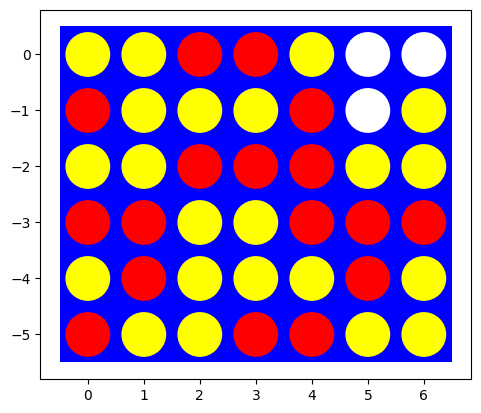

('move', 2) 




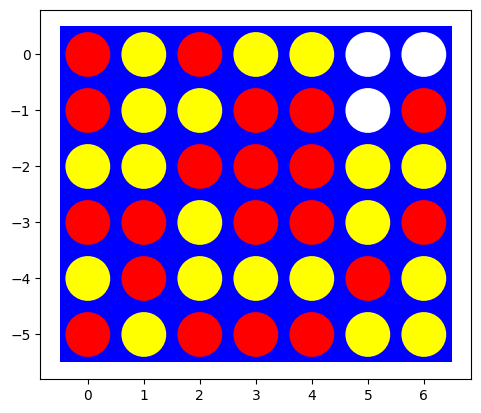

('add', 5) 




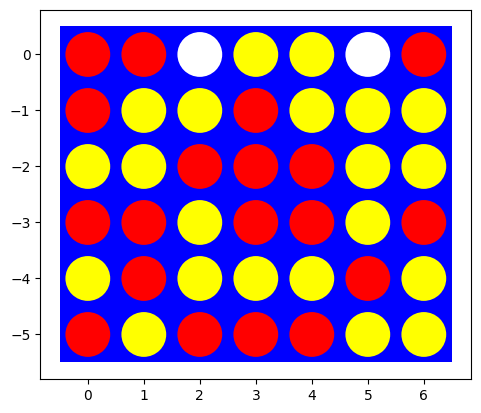

('move', 1) 




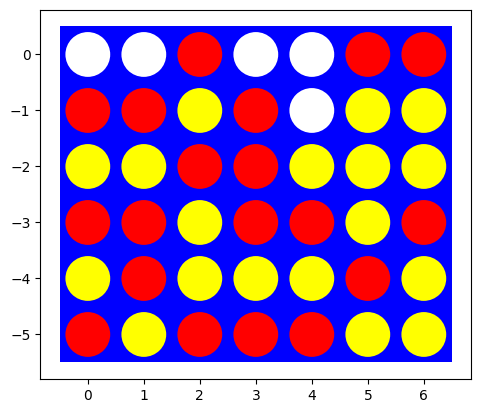

('add', 0) 




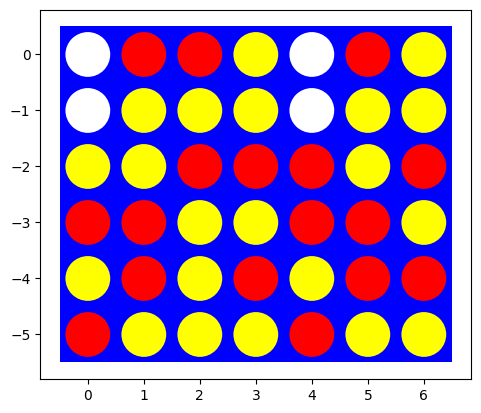

('move', 6) 


It does spot the same winning opportunities.


In [63]:
board = np.array([[-1, -1,  1,  1, -1,  0,  0],
                  [ 1, -1, -1, -1,  1,  0, -1],
                  [-1, -1,  1,  1,  1, -1, -1],
                  [ 1,  1, -1, -1,  1,  1,  1],
                  [-1,  1, -1, -1, -1,  1, -1],
                  [ 1, -1, -1,  1,  1, -1, -1]])
visualize(board)
print(minimax_player((board, 1, False), eval=close_to_connect_4, max_depth=10), "\n\n")

board = np.array([[ 1, -1,  1, -1, -1,  0,  0],
                  [ 1, -1, -1,  1,  1,  0,  1],
                  [-1, -1,  1,  1,  1, -1, -1],
                  [ 1,  1, -1,  1,  1, -1,  1],
                  [-1,  1, -1, -1, -1,  1, -1],
                  [ 1, -1,  1,  1,  1, -1, -1]])
visualize(board)
print(minimax_player((board, 1, False), eval=close_to_connect_4, max_depth=10), "\n\n")

board = np.array([[ 1,  1,  0, -1, -1,  0,  1],
                  [ 1, -1, -1,  1, -1, -1, -1],
                  [-1, -1,  1,  1,  1, -1, -1],
                  [ 1,  1, -1,  1,  1, -1,  1],
                  [-1,  1, -1, -1, -1,  1, -1],
                  [ 1, -1,  1,  1,  1, -1, -1]])
visualize(board)
print(minimax_player((board, 1, False), eval=close_to_connect_4, max_depth=10), "\n\n")

board = np.array([[ 0,  0,  1,  0,  0,  1,  1],
                  [ 1,  1, -1,  1,  0, -1, -1],
                  [-1, -1,  1,  1, -1, -1, -1],
                  [ 1,  1, -1,  1,  1, -1,  1],
                  [-1,  1, -1, -1, -1,  1, -1],
                  [ 1, -1,  1,  1,  1, -1, -1]])
visualize(board)
print(minimax_player((board, 1, False), eval=close_to_connect_4, max_depth=10), "\n\n")

board = np.array([[ 0,  1,  1, -1,  0,  1, -1],
                  [ 0, -1, -1, -1,  0, -1, -1],
                  [-1, -1,  1,  1,  1, -1,  1],
                  [ 1,  1, -1, -1,  1,  1, -1],
                  [-1,  1, -1,  1, -1,  1,  1],
                  [ 1, -1, -1, -1,  1, -1, -1]])
visualize(board)
print(minimax_player((board, 1, False), eval=close_to_connect_4, max_depth=10), "\n\n")

print("It does spot the same winning opportunities.")

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

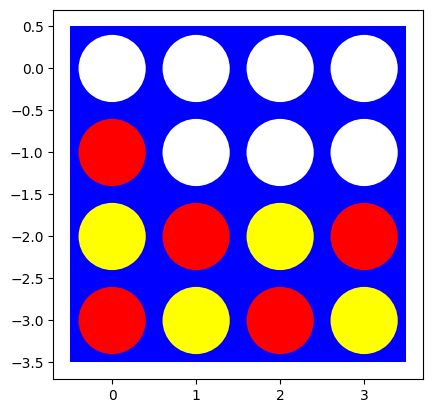

('add', 0)
The 4x4 board took: 0.38572072982788086 seconds




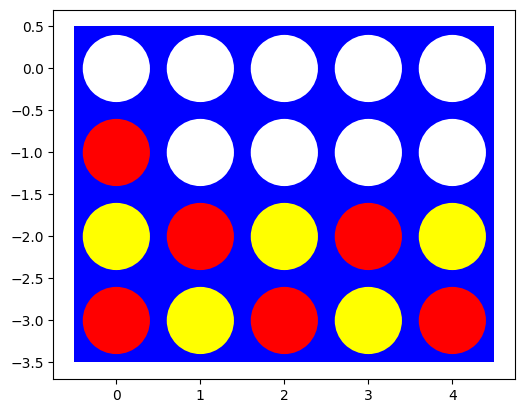

('add', 0)
The 4x5 board took: 3.058265447616577 seconds




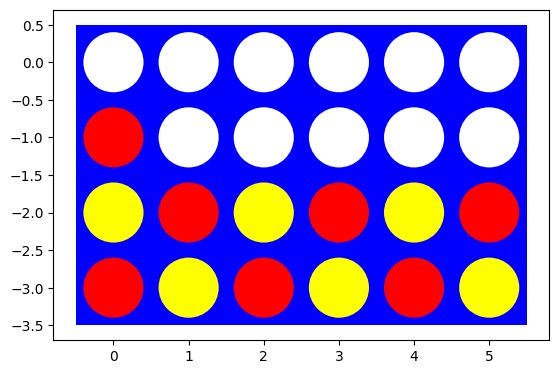

('add', 0)
The 4x6 board took: 14.056957960128784 seconds


These are the same boards that were used with minimax search without a heuristic evaluation function.
However, heuristic alpha-beta tree search played moves in much less time.


In [64]:
board = np.array([[ 0,  0,  0,  0],
                  [ 1,  0,  0,  0],
                  [-1,  1, -1,  1],
                  [ 1, -1,  1, -1]])
visualize(board)
t0 = time.time()
print(minimax_player((board, 1, False), eval=close_to_connect_4, max_depth=10))
t1 = time.time()
print(f"The 4x4 board took: {t1-t0} seconds\n\n")

board = np.array([[ 0,  0,  0,  0,  0],
                  [ 1,  0,  0,  0,  0],
                  [-1,  1, -1,  1, -1],
                  [ 1, -1,  1, -1,  1]])
visualize(board)
t0 = time.time()
print(minimax_player((board, 1, False), eval=close_to_connect_4, max_depth=10))
t1 = time.time()
print(f"The 4x5 board took: {t1-t0} seconds\n\n")

board = np.array([[ 0,  0,  0,  0,  0,  0],
                  [ 1,  0,  0,  0,  0,  0],
                  [-1,  1, -1,  1, -1,  1],
                  [ 1, -1,  1, -1,  1, -1]])
visualize(board)
t0 = time.time()
print(minimax_player((board, 1, False), eval=close_to_connect_4, max_depth=10))
t1 = time.time()
print(f"The 4x6 board took: {t1-t0} seconds\n\n")

print("These are the same boards that were used with minimax search without a heuristic evaluation function.")
print("However, heuristic alpha-beta tree search played moves in much less time.")

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

Different heuristic evaluation function (close_to_connect_4 vs disc_difference) but same cutoff depth (6):


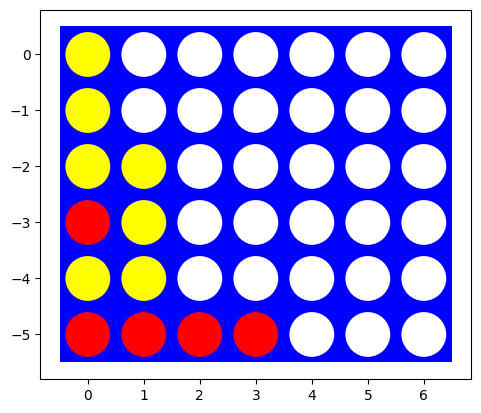

{'x': 1, 'y': 0, 't': 0}


Different heuristic evaluation function (disc_difference vs close_to_connect_4) but same cutoff depth (6):


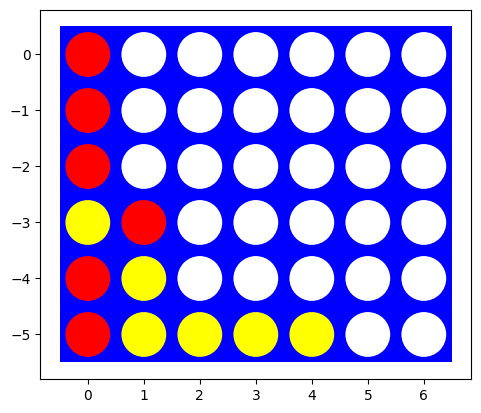

{'x': 0, 'y': 1, 't': 0}


Same heuristic evaluation function (close_to_connect_4) but different cutoff depths (7 vs 5):


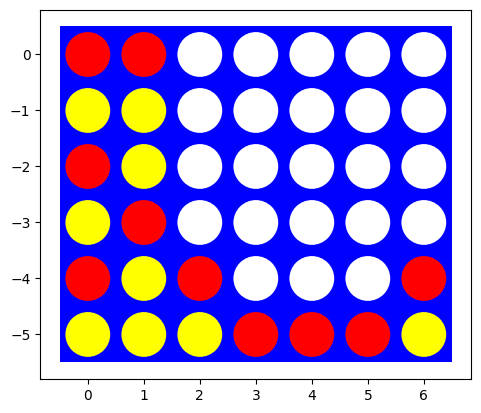

{'x': 1, 'y': 0, 't': 0}


Same heuristic evaluation function (disc_difference) but different cutoff depths (7 vs 5):


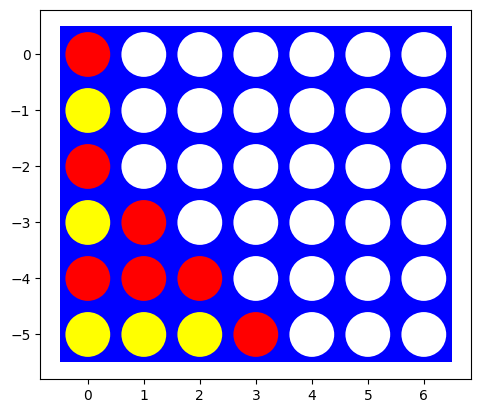

{'x': 1, 'y': 0, 't': 0}


In [65]:
print("Different heuristic evaluation function (close_to_connect_4 vs disc_difference) but same cutoff depth (6):")
print(play(minimax_player, minimax_player, 1, size=(6,7), show=True, eval1=close_to_connect_4, eval2=disc_difference, max_depth1=6, max_depth2=6))
print("\n")

print("Different heuristic evaluation function (disc_difference vs close_to_connect_4) but same cutoff depth (6):")
print(play(minimax_player, minimax_player, 1, size=(6,7), show=True, eval1=disc_difference, eval2=close_to_connect_4, max_depth1=6, max_depth2=6))
print("\n")

print("Same heuristic evaluation function (close_to_connect_4) but different cutoff depths (7 vs 5):")
print(play(minimax_player, minimax_player, 1, size=(6,7), show=True, eval1=close_to_connect_4, eval2=close_to_connect_4, max_depth1=7, max_depth2=5))
print("\n")

print("Same heuristic evaluation function (disc_difference) but different cutoff depths (7 vs 5):")
print(play(minimax_player, minimax_player, 1, size=(6,7), show=True, eval1=disc_difference, eval2=disc_difference, max_depth1=7, max_depth2=5))

---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
